In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,...,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_name_ingredients,combined_texts,prep_time_str,allergen_type_str,combined_all
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",...,doddapatre tambuli karpooravalli thayir pachadi,begin make doddapatre tambuli first thoroughly...,doddapatre tambuli popular healing nourish col...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...,30.0,Dairy,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",...,fish tandoori,begin make fish tandoori keep head tail remove...,ever try fish tandoori trust equally delicious...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...,80.0,Fish and Shellfish,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",...,arbi shimla mirch sabzi colocasia capsicum sabzi,begin make arbi shimla mirch sabzi first cook ...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...,55.0,"Tree Nuts and Peanuts, Legumes and Seeds",arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...",...,ambur style brinjal curry,begin make ambur style brinjal curry add oil h...,brinjal curry prepare different way different ...,"[Legumes and Seeds, Tree Nuts and Peanuts]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...,20.0,"Legumes and Seeds, Tree Nuts and Peanuts",ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",...,mavinakayi menasinakai curry raw mango coconut...,begin make mangalorean mavinakayi menasinakai ...,mangalorean mavinakayi menasinakai curry mango...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...,35.0,Legumes and Seeds,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,Alu Vadi Or Patrode Recipe - Maharashtrian Sna...,"Colocasia Leaves (Arbi), Multigrain flour, Tam...",Alu vadi or P

Note:
"combined_name_ingredients" column includes the combined contexts of "processed_name", and "processed_ingredients" columns.
"combinded_texts" column includes the combined contexts of "processed_name", "processed_ingredients", "processed_instructions", and "processed_description" columns. 
"combined_all" column includes the combined cotexts of all eight columns of "processed_name", "processed_ingredients", "processed_instructions", "processed_description", "cuisine", "course", "diet", "prep_time", and "allergen_type".

Train SVD model on TF-IDF and Count vectorizers and find the best number of topics using coherence scores

In [3]:
def compute_coherence_scores_svd(texts, vectorizer, num_topics_range):
    coherence_scores = []
    
    # Transform texts to TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in `texts` for coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
        svd_matrix = svd_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in svd_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.rc('font', family='Arial', size=12)
    plt.show()
    
    # Find the best number of topics
    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")

    return coherence_scores, best_num_topics

Compare the performance of the SVD model on TF-IDF using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns separately

Number of Topics: 10, Coherence Score: 0.36134933630739074
Number of Topics: 11, Coherence Score: 0.3285079051280224
Number of Topics: 12, Coherence Score: 0.32131632153427764
Number of Topics: 13, Coherence Score: 0.3436057712740575
Number of Topics: 14, Coherence Score: 0.3154007727790858
Number of Topics: 15, Coherence Score: 0.3302922773533276
Number of Topics: 16, Coherence Score: 0.32370045535816583
Number of Topics: 17, Coherence Score: 0.3092338361541042
Number of Topics: 18, Coherence Score: 0.2992249396816327
Number of Topics: 19, Coherence Score: 0.3085777720222329
Number of Topics: 20, Coherence Score: 0.31124104125925833


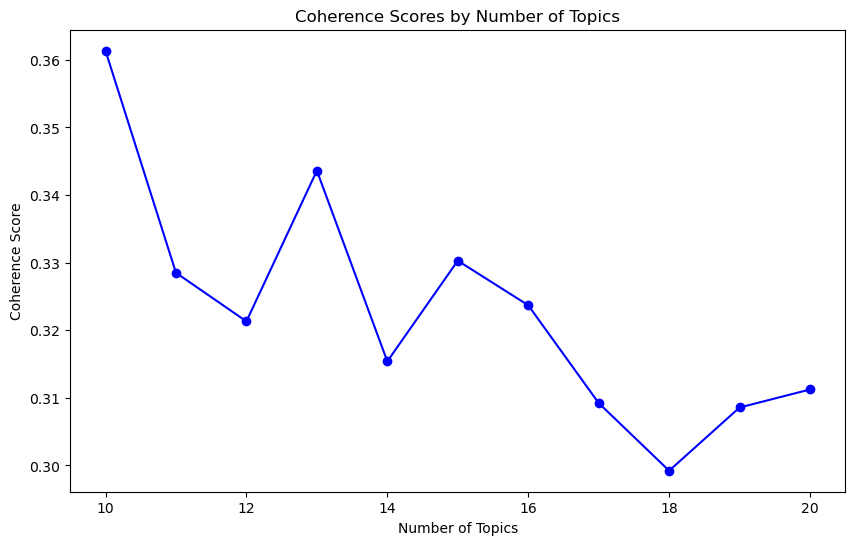

Best Number of Topics: 10 with Coherence Score: 0.36134933630739074


In [4]:
name_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['processed_name'], TfidfVectorizer(), range(10, 21, 1))

Number of Topics: 1, Coherence Score: 0.70311630317845
Number of Topics: 2, Coherence Score: 0.8102030943873642
Number of Topics: 3, Coherence Score: 0.6992679145031794
Number of Topics: 4, Coherence Score: 0.6781824472030646
Number of Topics: 5, Coherence Score: 0.6385339582350517
Number of Topics: 6, Coherence Score: 0.6153712176716746
Number of Topics: 7, Coherence Score: 0.6531370274926955
Number of Topics: 8, Coherence Score: 0.6308509084242526


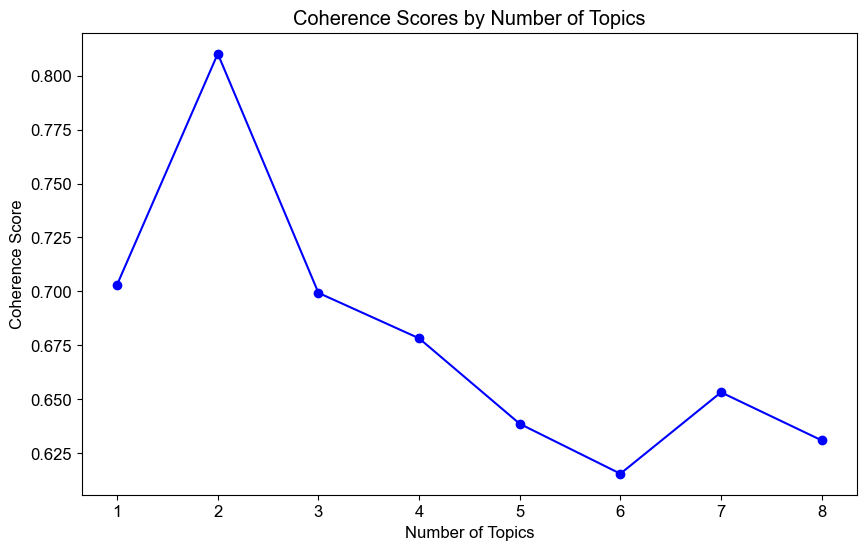

Best Number of Topics: 2 with Coherence Score: 0.8102030943873642


In [5]:
name_ingredients_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 1, Coherence Score: 0.5544670970848786
Number of Topics: 2, Coherence Score: 0.6410569803465395
Number of Topics: 3, Coherence Score: 0.6196940097005732
Number of Topics: 4, Coherence Score: 0.5454655579025682
Number of Topics: 5, Coherence Score: 0.5335730305814917
Number of Topics: 6, Coherence Score: 0.48539407891377406
Number of Topics: 7, Coherence Score: 0.4668914320735271
Number of Topics: 8, Coherence Score: 0.46197834140772254


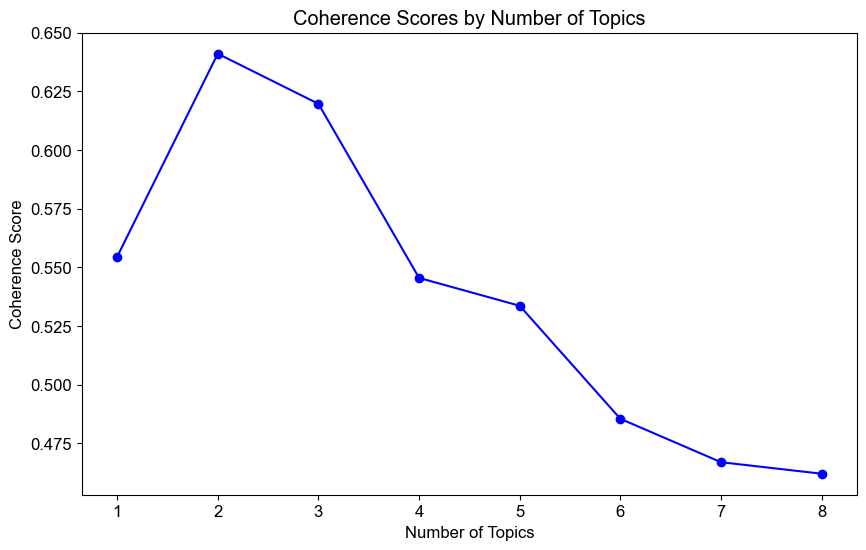

Best Number of Topics: 2 with Coherence Score: 0.6410569803465395


In [6]:
texts_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_texts'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 1, Coherence Score: 0.5588867306254145
Number of Topics: 2, Coherence Score: 0.6414941910314003
Number of Topics: 3, Coherence Score: 0.6196546459147524
Number of Topics: 4, Coherence Score: 0.5516108460920276
Number of Topics: 5, Coherence Score: 0.5374814957316804
Number of Topics: 6, Coherence Score: 0.489318132640523
Number of Topics: 7, Coherence Score: 0.46225012410435806
Number of Topics: 8, Coherence Score: 0.45774202315516455


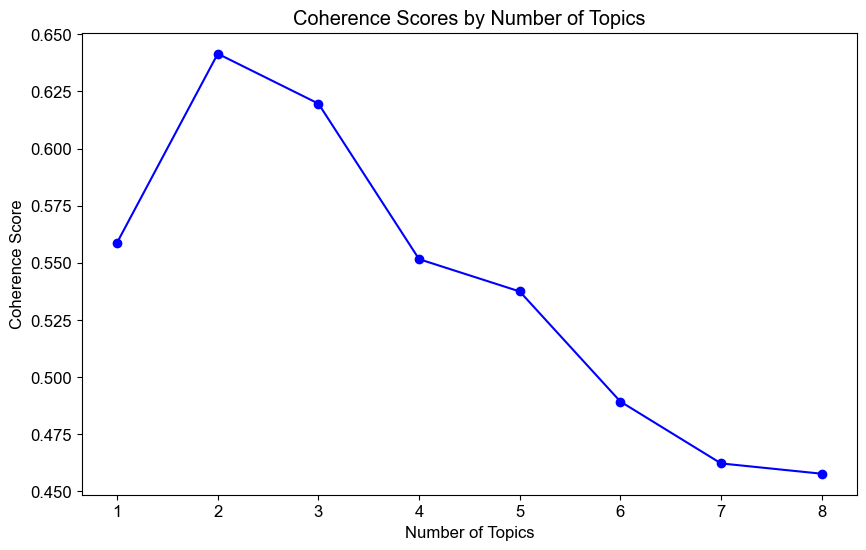

Best Number of Topics: 2 with Coherence Score: 0.6414941910314003


In [7]:
all_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_all'], TfidfVectorizer(), range(1, 9, 1))

Compare the performance of the SVD model on Count vectorizer using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns separately

Number of Topics: 1, Coherence Score: 0.3179624265887323
Number of Topics: 2, Coherence Score: 0.3068515921581606
Number of Topics: 3, Coherence Score: 0.47928671172218845
Number of Topics: 4, Coherence Score: 0.466426181766631
Number of Topics: 5, Coherence Score: 0.4630432951746727
Number of Topics: 6, Coherence Score: 0.47892977454653596
Number of Topics: 7, Coherence Score: 0.4708004740383626
Number of Topics: 8, Coherence Score: 0.4033079397888427
Number of Topics: 9, Coherence Score: 0.4217908970611724
Number of Topics: 10, Coherence Score: 0.42397281212320737


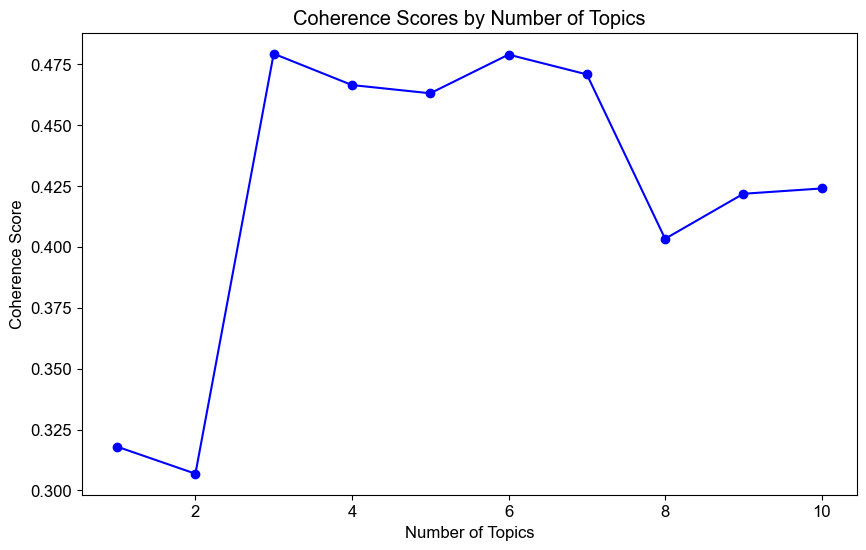

Best Number of Topics: 3 with Coherence Score: 0.47928671172218845


In [8]:
name_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['processed_name'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.7229284187587682
Number of Topics: 2, Coherence Score: 0.8108869307612789
Number of Topics: 3, Coherence Score: 0.7965682935763709
Number of Topics: 4, Coherence Score: 0.7290819627971288
Number of Topics: 5, Coherence Score: 0.666768749320431
Number of Topics: 6, Coherence Score: 0.6559984537868746
Number of Topics: 7, Coherence Score: 0.6288566992642829
Number of Topics: 8, Coherence Score: 0.6084942981306233
Number of Topics: 9, Coherence Score: 0.5847542628412589
Number of Topics: 10, Coherence Score: 0.57795218944041


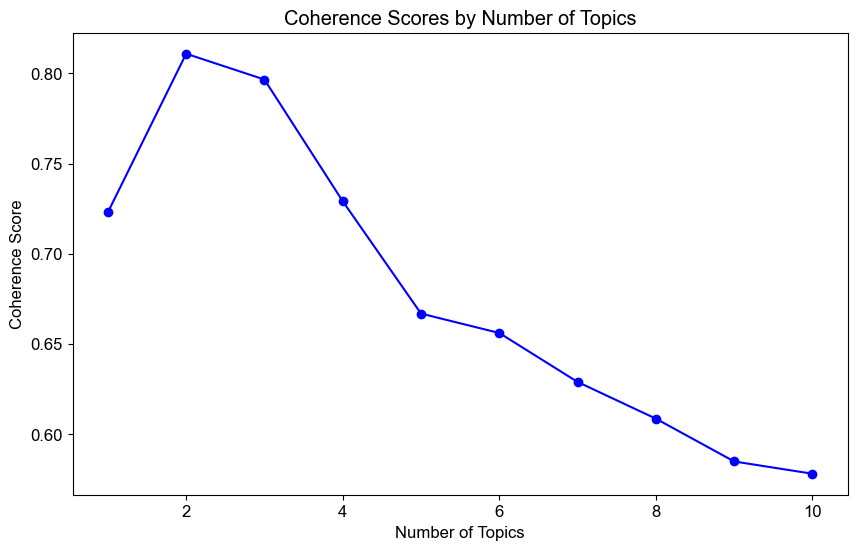

Best Number of Topics: 2 with Coherence Score: 0.8108869307612789


In [9]:
name_ingredients_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.47917382802990083
Number of Topics: 2, Coherence Score: 0.5174848620489327
Number of Topics: 3, Coherence Score: 0.4749621101236519
Number of Topics: 4, Coherence Score: 0.48066054386666873
Number of Topics: 5, Coherence Score: 0.46709219830668036
Number of Topics: 6, Coherence Score: 0.4413836422082042
Number of Topics: 7, Coherence Score: 0.47260244140441926
Number of Topics: 8, Coherence Score: 0.458193289578223
Number of Topics: 9, Coherence Score: 0.4638663881586759
Number of Topics: 10, Coherence Score: 0.4509826027785489


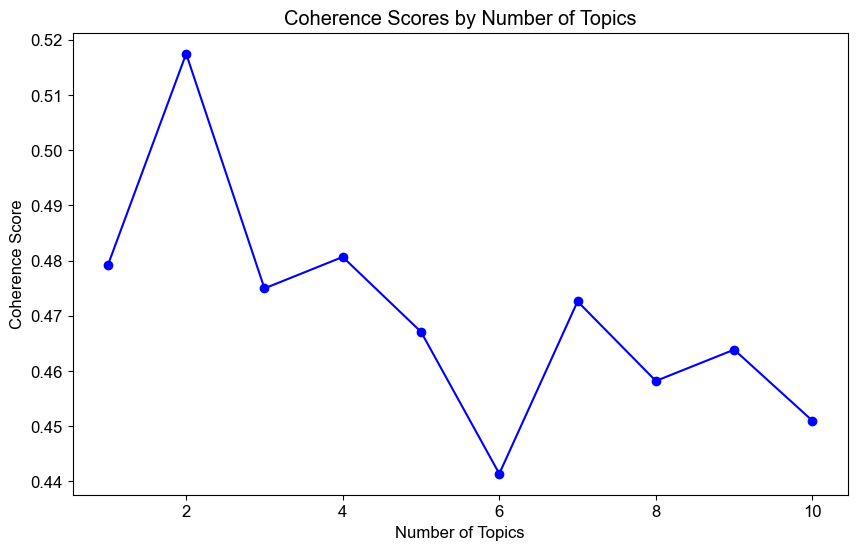

Best Number of Topics: 2 with Coherence Score: 0.5174848620489327


In [10]:
texts_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_texts'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.4912878514376281
Number of Topics: 2, Coherence Score: 0.523599947071695
Number of Topics: 3, Coherence Score: 0.4787160764800891
Number of Topics: 4, Coherence Score: 0.484000927817134
Number of Topics: 5, Coherence Score: 0.4726522710434947
Number of Topics: 6, Coherence Score: 0.4459658516328268
Number of Topics: 7, Coherence Score: 0.4824161969635327
Number of Topics: 8, Coherence Score: 0.4603895489726363
Number of Topics: 9, Coherence Score: 0.4678235071617898
Number of Topics: 10, Coherence Score: 0.4542559514280149


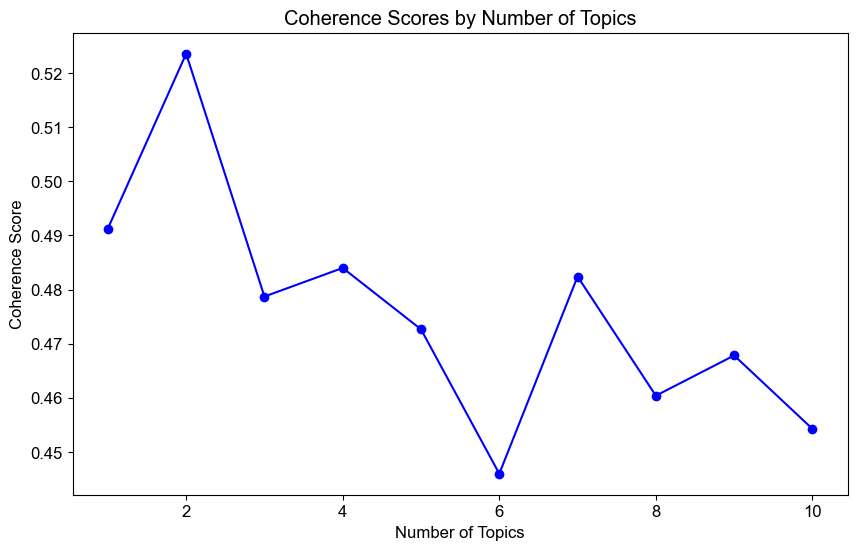

Best Number of Topics: 2 with Coherence Score: 0.523599947071695


In [11]:
all_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_all'], CountVectorizer(), range(1, 11, 1))

Choose the best combination of data based on the highest coherence score of models

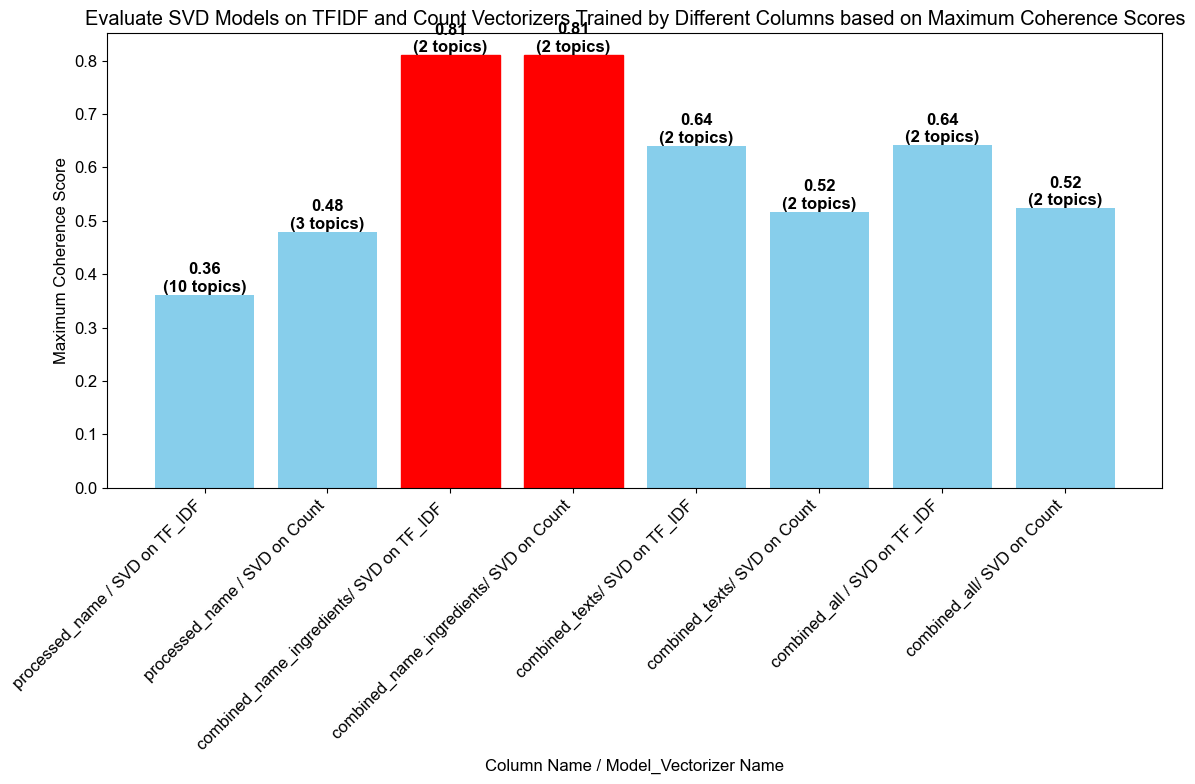

In [12]:
coherence_scores_dict = {"processed_name / SVD on TF_IDF": name_coherence_scores_svd_tfidf[0],
    "processed_name / SVD on Count": name_coherence_scores_svd_countvect[0],                  
    "combined_name_ingredients/ SVD on TF_IDF ": name_ingredients_coherence_scores_svd_tfidf[0],
    "combined_name_ingredients/ SVD on Count": name_ingredients_coherence_scores_svd_countvect[0],
    "combined_texts/ SVD on TF_IDF": texts_coherence_scores_svd_tfidf[0], 
    "combined_texts/ SVD on Count": texts_coherence_scores_svd_countvect[0],
    "combined_all / SVD on TF_IDF": all_coherence_scores_svd_tfidf[0], 
    "combined_all/ SVD on Count": all_coherence_scores_svd_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_svd_tfidf[1], name_coherence_scores_svd_countvect[1], 
                   name_ingredients_coherence_scores_svd_tfidf[1], name_ingredients_coherence_scores_svd_countvect[1], 
                   texts_coherence_scores_svd_tfidf[1], texts_coherence_scores_svd_countvect[1],
                   all_coherence_scores_svd_tfidf[1], all_coherence_scores_svd_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

# Get indices of the two highest scores
top_two_indices = sorted(range(len(max_scores)), key=lambda i: max_scores[i], reverse=True)[:2]

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bars with the two highest coherence scores in red
for idx in top_two_indices:
    bars[idx].set_color('red')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Evaluate SVD Models on TFIDF and Count Vectorizers Trained by Different Columns based on Maximum Coherence Scores")

# Align x-ticks directly under bars
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.rc('font', family='Arial', size=12)

plt.tight_layout()
plt.show()